In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import dask.dataframe as dd
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import joblib

from multiprocessing import Pool
from concurrent.futures import ThreadPoolExecutor, as_completed

from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix

2024-09-22 02:35:15.984488: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-22 02:35:16.035541: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9360] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-22 02:35:16.035586: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-22 02:35:16.035616: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1537] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-22 02:35:16.044635: I tensorflow/core/platform/cpu_feature_g

In [2]:
NUM_CLASSES = 2
CLASSES = np.array(['Legitimate', 'Suspicious'])
DATASET_DIR = "./"
VECTOR_LENGTH = 1 * 275

def csvToVector(file_path):
    data = pd.read_csv(file_path, header=None)
    vector = data.values.flatten()
    return vector

def process_file(class_idx, file_path):
    vector = csvToVector(file_path)
    return (vector, class_idx)

def load_data(dataset_dir):
    X = []
    y = []
    subdirs = ['benign_cms3', 'malware_cms3']
    futures = []

    with ThreadPoolExecutor() as executor:
        for class_idx, class_name in enumerate(subdirs):
            class_dir = os.path.join(dataset_dir, class_name)
            for file_name in os.listdir(class_dir):
                if file_name.endswith('.csv'):
                    file_path = os.path.join(class_dir, file_name)
                    futures.append(executor.submit(process_file, class_idx, file_path))

        for future in as_completed(futures):
            vector, class_idx = future.result()
            X.append(vector)
            y.append(class_idx)

    X = np.array(X)
    y = np.array(y)
    return X, y

In [3]:
X, y = load_data(DATASET_DIR)

In [4]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.3, random_state=42)

#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_train = X_train / 299.0
#X_val = X_val / 299.0
X_test = X_test / 299.0

In [5]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

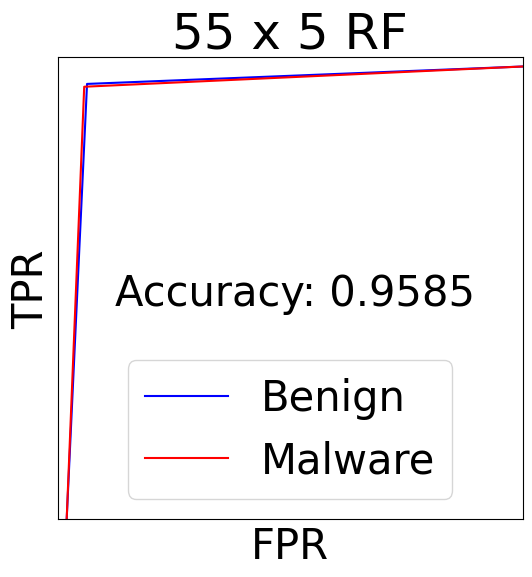

<Figure size 640x480 with 0 Axes>

In [8]:
y_pred_proba = dt_model.predict_proba(X_test)

y_test_binary = y_test

class_labels = ['Benign', 'Malware']
colors = ['blue', 'red']

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(class_labels)):
    fpr[i], tpr[i], _ = roc_curve(y_test_binary == i, y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(6, 6))
plt.rcParams.update({'font.size': 30})
for i in range(len(class_labels)):
    plt.plot(fpr[i], tpr[i],color=colors[i], label=f'{class_labels[i]}')
    
accuracy = np.mean(y_test_binary == np.argmax(y_pred_proba, axis=1))
plt.text(0.5, 0.5, f'Accuracy: {accuracy:.4f}', fontsize=30, ha='center', va='center')

plt.plot([0, 1], [0, 1], 'None')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.02])
plt.xticks([])
plt.yticks([])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('55 x 5 RF')
plt.legend(loc="lower center")
plt.show()
plt.savefig('cms3_rf.pdf', format='pdf')

In [7]:
#y_val_pred = dt_model.predict(X_val)
y_test_pred = dt_model.predict(X_test)

#print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))

#print("Validation Classification Report:\n", classification_report(y_val, y_val_pred, target_names=CLASSES))
print("Test Classification Report:\n", classification_report(y_test, y_test_pred, target_names=CLASSES, digits=4))

#print("Validation Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))
print("Test Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

Test Accuracy: 0.9585406301824212
Test Classification Report:
               precision    recall  f1-score   support

  Legitimate     0.9585    0.9615    0.9600       624
  Suspicious     0.9586    0.9553    0.9570       582

    accuracy                         0.9585      1206
   macro avg     0.9585    0.9584    0.9585      1206
weighted avg     0.9585    0.9585    0.9585      1206

Test Confusion Matrix:
 [[600  24]
 [ 26 556]]
